# Task

Include the curvature as an extra parameter to your likelihood

In [22]:
import numpy as np
import scipy.integrate as integrate
def E(z,OmDE,OmM):
    """
    This function computes the integrand for the computation of the luminosity distance for a flat universe
    z -> float
    OmDE -> float
    OmM -> float
    gives
    E -> float
    """
    Omk=1-OmDE-OmM
    return 1/np.sqrt(OmM*(1+z)**3+OmDE+Omk*(1+z)**2)

def dl(z,OmDE,OmM,h=0.7):
    """
    This function computes the luminosity distance
    z -> float
    OmDE -> float
    h ->float
    returns
    dl -> float
    """
    inte=integrate.quad(E,0,z,args=(OmDE,OmM))
    # Velocidad del sonido en km/s
    c = 299792.458
    # Factor de Hubble
    Ho = 100*h
    Omk=1-OmDE-OmM
    distance_factor = c*(1+z)/Ho 
    if Omk>1e-10:
        omsqrt = np.sqrt(Omk)
        return distance_factor / omsqrt * np.sinh(omsqrt * inte[0])
    elif Omk<-1e-10:
        omsqrt = np.sqrt(-Omk)
        return distance_factor / omsqrt * np.sin(omsqrt * inte[0])
    else:
        return distance_factor * inte[0]
        
zandmu = np.loadtxt('../data/SCPUnion2.1_mu_vs_z.txt', skiprows=5,usecols=(1,2))
covariance = np.loadtxt('../data/SCPUnion2.1_covmat_sys.txt')
inv_cov = np.linalg.inv(covariance)
dl = np.vectorize(dl)
def loglike(params,h=0.7):
    """
    This function computes the logarithm of the likelihood. It recieves a vector
    params-> vector with one component (Omega Dark Energy, Omega Matter)
    """
    OmDE = params[0]
    OmM = params[1]
    
# Ahora quiero calcular la diferencia entre el valor reportado y el calculado
    muteo = 5.*np.log10(dl(zandmu[:,0],OmDE,OmM,h))+25
    print dl(zandmu[:,0],OmDE,OmM,h)
    delta = muteo-zandmu[:,1]
    chisquare=np.dot(delta,np.dot(inv_cov,delta))
    return -chisquare/2

In [23]:
loglike([0.6,0.3])

[  124.49991645   221.9519845    235.19437877   315.01464654   280.30054274
   398.16872828   355.13700562    74.69441739   186.32391817   200.24947027
   160.31028142    85.12150513   462.63402574   119.39634308   336.31701323
   115.6027417    221.39726375   133.94400866    70.82877222    66.84536093
   133.60881064   106.88479466   104.35013699   113.59875216   216.93512001
   105.94957723    65.66227159   156.88846553   216.33997794    95.62254675
   578.62507067   158.14873404    70.72076469    72.51399085   120.09950749
    94.79654368    71.28624429   101.05184314   160.20667596    83.64680252
    76.35377708   138.07641535   102.50356443    72.57100498   238.80391119
    73.65885622   121.72448069    74.45743702   131.04454584    71.76413169
    64.93591907   241.98363811   739.88139973   173.03706576   577.12450115
   678.2145442    606.22116269   354.29644133   260.00817551   135.26725278
   178.91993387    65.81106334    97.47842798    69.31408134   159.04921193
    75.01480

-274.10488550524985

In [2]:
def markovchain(steps, step_width, pasoinicial):
    chain=[pasoinicial]
    likechain=[loglike(chain[0])]
    accepted = 0
    for i in range(steps):
        rand = np.random.normal(0.,1.,len(pasoinicial))
        newpoint = chain[i] + step_width*rand
        liketry = loglike(newpoint)
        if np.isnan(liketry) :
            print 'Paso algo raro'
            liketry = -1E50
            accept_prob = 0
        elif liketry > likechain[i]:
            accept_prob = 1
        else:
            accept_prob = np.exp(liketry - likechain[i])

        if accept_prob >= np.random.uniform(0.,1.):
            chain.append(newpoint)
            likechain.append(liketry)
            accepted += 1
        else:
            chain.append(chain[i])
            likechain.append(likechain[i])
    chain = np.array(chain)
    likechain = np.array(likechain)

    print "Razon de aceptacion =",float(accepted)/float(steps)

    return chain, likechain

In [3]:
chain1, likechain1 = markovchain(100,[0.1,0.1],[0.7,0.3])

Razon de aceptacion = 0.44


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

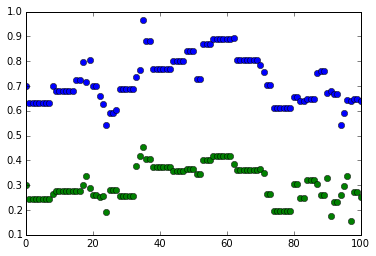

In [5]:
plt.plot(chain1[:,0],'o')
plt.plot(chain1[:,1],'o')

In [6]:
columna1=chain1[:,0]
np.sqrt(np.mean(columna1**2)-np.mean(columna1)**2)

0.094182964516509399

# Now let's analize the chains

First just an histogram

In [7]:
import seaborn as sns

In [8]:
omegade=chain1[:,0]
omegadm=chain1[:,1]

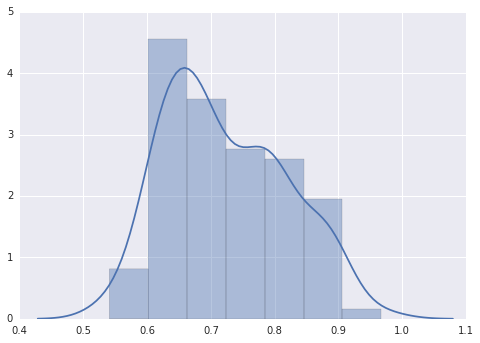

In [9]:
sns.distplot(omegade)

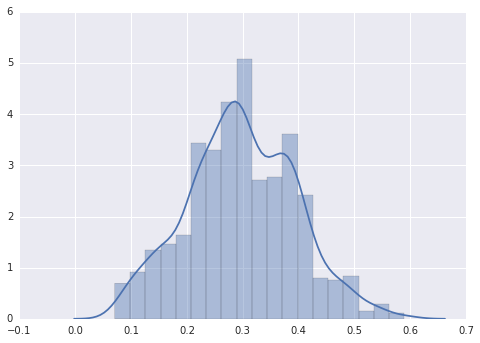

In [10]:
sns.distplot(omegadm)

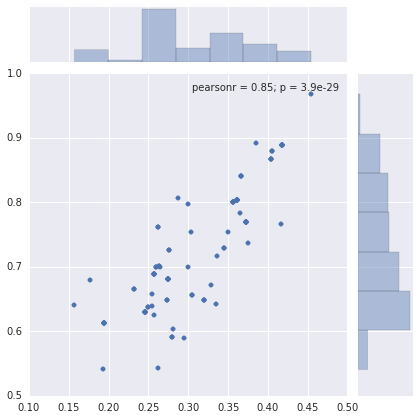

In [10]:
sns.jointplot(x=omegadm,y=omegade)

In [11]:
import corner

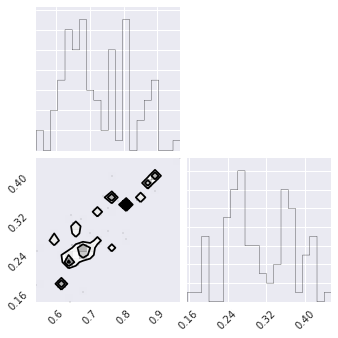

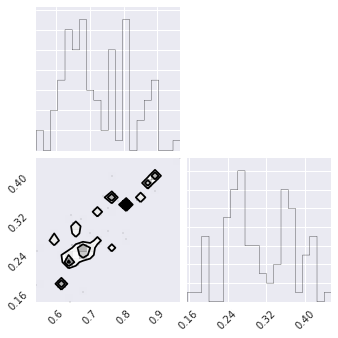

In [12]:
corner.corner(chain1)

How to obtain the confidence regions of a variable?

In [13]:
mean_de=np.mean(omegade)
print(mean_de)

0.723519010223


You can use the "central credible interval"

In [14]:
dimde=len(omegade)
points_outside = np.int((1-0.68)*dimde/2)
de_sorted=np.sort(omegade)
print de_sorted[points_outside], de_sorted[dimde-points_outside]

0.629694556722 0.840268026527


In [28]:
dimde=len(omegade)
points_outside = np.int((1-0.95)*dimde/2)
de_sorted=np.sort(omegade)
print de_sorted[points_outside], de_sorted[dimde-points_outside]

0.441054715189 0.981563215272
